# CAFA-6 Protein Function Prediction
In this notebook we try to submit a valid solution for the _CAFA-6 Protein Function Prediction_ Kaggle competition.



### Imports

In [1]:
!pip install -q biopython obonet torchmetrics

import os, gc, sys, math, random, warnings
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MultilabelF1Score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from tqdm.auto import tqdm
from Bio import SeqIO
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.6 MB/s eta 0:00:00


### Configuration

In [2]:
class CFG:
    # Paths
    TRAIN_TERMS = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv'
    TRAIN_SEQS  = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta'
    TRAIN_TAX   = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv'

    TEST_SEQS   = '/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta'
    TEST_TAX    = '/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv'

    OBO_FILE    = '/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo'

    EMBEDDINGS_PATH = '/kaggle/input/cafa6-protein-embeddings-esm2/protein_embeddings.npy'
    EMBEDDINGS_IDS  = '/kaggle/input/cafa6-protein-embeddings-esm2/protein_ids.csv'

    # GOA baseline/corrections file 
    GOA_PATH = '/kaggle/input/goa-uniprot-all/selection_ids_goa_uniprot_all.csv'

    # IA weights file 
    IA_PATH = '/kaggle/input/cafa-6-protein-function-prediction/IA.tsv' 

    # Global
    SEED = 42
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Inference thresholds by aspect
    THRESHOLDS = {'C': 0.08, 'F': 0.08, 'P': 0.01}
    MIN_PREDS = 25

    # Training
    VAL_SPLIT = 0.10
    NUM_WORKERS = 4
    PIN_MEMORY = True

    # Early stopping
    EARLY_STOP_PATIENCE = 5
    EARLY_STOP_MIN_DELTA = 1e-4  

    # Mixed precision (safe on T4)
    USE_AMP = True

    # Ensemble configurations (3 heterogeneous MLP)
    ENSEMBLE_CONFIGS = [
        {'NAME': 'Aggressive',   'BS': 32, 'EPOCHS': 40, 'LR': 1e-3, 'D1': 1024, 'D2': 512,  'DROP': 0.3},
        {'NAME': 'WideRobust',   'BS': 32, 'EPOCHS': 40, 'LR': 1e-3, 'D1': 2048, 'D2': 1024, 'DROP': 0.4},
        {'NAME': 'BalancedMid',  'BS': 32, 'EPOCHS': 40, 'LR': 1e-3, 'D1': 1024, 'D2': 768,  'DROP': 0.3},
    ]

    # Loss choice
    USE_IA_WEIGHTED_BCE = False

print("Using device:", CFG.DEVICE)
print("Ensembling", len(CFG.ENSEMBLE_CONFIGS), "models per aspect")


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.SEED)


Using device: cuda
Ensembling 3 models per aspect


### Helper functions

In [3]:
def plot_history(history, aspect_name, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(epochs, history['train_loss'], 'r-o', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'b-s', label='Val Loss')
    ax1.set_title(f'{aspect_name} [{model_name}] - Loss')
    ax1.legend(); ax1.grid(True)

    ax2.plot(epochs, history['val_f1'], 'g-^', label='Val F1')
    ax2.set_title(f'{aspect_name} [{model_name}] - F1 Score')
    ax2.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.show()


def parse_obo_parents(obo_file: str):
    print(f"\nParsing GO parents from {os.path.basename(obo_file)} ...")
    go_parents = defaultdict(list)
    current_term = None
    with open(obo_file, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("id: GO:"):
                current_term = line.split("id: ")[1]
            elif line.startswith("is_a:") and current_term:
                go_parents[current_term].append(line.split("is_a: ")[1].split(" !")[0].strip())
            elif line.startswith("relationship: part_of") and current_term:
                go_parents[current_term].append(line.split("part_of ")[1].split(" !")[0].strip())
    print(f"Loaded {len(go_parents):,} GO terms with parents")
    return go_parents


def parse_obo_children(obo_file: str):
    # children map used for NOT propagation (descendants)
    go_children = defaultdict(list)
    current_term = None
    with open(obo_file, "r") as f:
        for line in f:
            line = line.strip()
            if line == "[Term]":
                current_term = None
            elif line.startswith("id: "):
                current_term = line[4:]
            elif line.startswith("is_a: ") and current_term:
                parent = line[5:].split(" ! ")[0]
                go_children[parent].append(current_term)
            elif line.startswith("relationship: part_of") and current_term:
                parent = line.split("part_of ")[1].split(" !")[0].strip()
                go_children[parent].append(current_term)
    return go_children


def get_all_ancestors(term: str, go_parents: dict, cache: dict):
    if term in cache:
        return cache[term]
    anc = set()
    for p in go_parents.get(term, []):
        anc.add(p)
        anc.update(get_all_ancestors(p, go_parents, cache))
    cache[term] = anc
    return anc


def get_descendants(term: str, children_map: dict, cache: dict):
    if term in cache:
        return cache[term]
    desc = set()
    stack = [term]
    while stack:
        cur = stack.pop()
        for kid in children_map.get(cur, []):
            if kid not in desc:
                desc.add(kid)
                stack.append(kid)
    cache[term] = desc
    return desc


def propagate_predictions_to_ancestors(df: pd.DataFrame, go_parents: dict):
    """
    df columns: pid, term, p
    output: add all ancestors with score=max(child score)
    """
    print("\nPropagating predictions to ancestors (is_a + part_of) ...")
    anc_cache = {}
    out_rows = []

    # groupby pid: keep max per term, then add ancestors
    for pid, grp in tqdm(df.groupby("pid"), total=df["pid"].nunique(), desc="Propagating"):
        term2p = {}
        # max per term
        for t, p in zip(grp["term"].values, grp["p"].values):
            prev = term2p.get(t)
            if (prev is None) or (p > prev):
                term2p[t] = p

        base_terms = list(term2p.keys())
        for t in base_terms:
            sc = term2p[t]
            for a in get_all_ancestors(t, go_parents, anc_cache):
                prev = term2p.get(a)
                if (prev is None) or (sc > prev):
                    term2p[a] = sc

        for t, sc in term2p.items():
            out_rows.append((pid, t, float(sc)))

    return pd.DataFrame(out_rows, columns=["pid", "term", "p"])


## Feature Engineering 
### Maunal Features and Taxonomy

In [4]:
class SequenceFeatureExtractor:
    """
    85-dim manual features:
    - 20 AA freq
    - 4 global props
    - 6 group feats
    - 20 di-gram freq (top list)
    - 20 tri-gram freq (top list)
    - 10 extra di-gram
    - 5 misc
    """
    STANDARD = 'ACDEFGHIKLMNPQRSTVWY'
    AA_WEIGHTS = {
        'A': 89, 'C': 121, 'D': 133, 'E': 147, 'F': 165, 'G': 75, 'H': 155, 'I': 131, 'K': 146,
        'L': 131, 'M': 149, 'N': 132, 'P': 115, 'Q': 146, 'R': 174, 'S': 105, 'T': 119, 'V': 117,
        'W': 204, 'Y': 181
    }
    GROUPS = {
        'hydro': 'AILMFWYV',
        'polar': 'STNQ',
        'pos':   'RK',
        'neg':   'DE',
        'arom':  'FWY',
        'aliph': 'ILV'
    }
    TOP_DI = ['AL','LA','LE','EA','AA','AS','SA','EL','LL','AE','SE','ES','GA','AG','VA','AV','LV','VL','LS','SL']
    TOP_TRI = ['ALA','LEA','EAL','LAL','AAA','LLE','ELE','ALE','GAL','ASA','VLA','LAV','SLS','LSL','GLA','LAG','AVL','VLA','SLE','LES']
    EXTRA_DI = ['RE','ER','VE','EV','TE','ET','AV','VA','GL','LG']

    @staticmethod
    def extract(seq: str):
        if not seq:
            return np.zeros(85, dtype=np.float32)
        try:
            length = len(seq)
            aa_counts = Counter(seq)

            aa_freq = np.array([aa_counts.get(aa, 0) / length for aa in SequenceFeatureExtractor.STANDARD], dtype=np.float32)

            hydrophobic = sum(aa_counts.get(aa, 0) for aa in 'AILMFWYV') / length
            charged = sum(aa_counts.get(aa, 0) for aa in 'DEKR') / length
            mol_weight = sum(aa_counts.get(aa, 0) * SequenceFeatureExtractor.AA_WEIGHTS.get(aa, 0) for aa in aa_counts)

            props = np.array([np.log1p(length), hydrophobic, charged, np.log1p(mol_weight)], dtype=np.float32)

            group_feats = np.array(
                [sum(aa_counts.get(aa, 0) for aa in chars) / length for chars in SequenceFeatureExtractor.GROUPS.values()],
                dtype=np.float32
            )

            # di-grams
            di_freq = np.zeros(20, dtype=np.float32)
            if length > 1:
                di_counts = Counter([seq[i:i+2] for i in range(length - 1)])
                di_freq = np.array([di_counts.get(dp, 0) / (length - 1) for dp in SequenceFeatureExtractor.TOP_DI], dtype=np.float32)

            # tri-grams (fixed variable name)
            tri_freq = np.zeros(20, dtype=np.float32)
            if length > 2:
                tri_counts = Counter([seq[i:i+3] for i in range(length - 2)])
                tri_freq = np.array([tri_counts.get(tp, 0) / (length - 2) for tp in SequenceFeatureExtractor.TOP_TRI], dtype=np.float32)

            # extra di-grams
            extra_freq = np.zeros(10, dtype=np.float32)
            if length > 1:
                di_counts = Counter([seq[i:i+2] for i in range(length - 1)])
                extra_freq = np.array([di_counts.get(dp, 0) / (length - 1) for dp in SequenceFeatureExtractor.EXTRA_DI], dtype=np.float32)

            arom = sum(aa_counts.get(aa, 0) for aa in 'FWY') / length
            instab = (hydrophobic + charged) / 2
            iso = np.mean([ord(aa) for aa in seq[:100]]) / 255.0 if seq else 0.0

            misc = np.array([arom, instab, iso, 0.0, 0.0], dtype=np.float32)

            return np.concatenate([aa_freq, props, group_feats, di_freq, tri_freq, extra_freq, misc]).astype(np.float32)
        except Exception:
            return np.zeros(85, dtype=np.float32)


def parse_fasta(path: str):
    seqs, feats = {}, {}
    print(f"\nParsing {os.path.basename(path)} ...")
    for rec in tqdm(SeqIO.parse(path, "fasta"), total=None):
        pid = rec.id.split('|')[1] if '|' in rec.id else rec.id.split()[0]
        s = str(rec.seq)
        seqs[pid] = s
        feats[pid] = SequenceFeatureExtractor.extract(s)
    return seqs, feats


def load_taxonomy(train_tax_path: str, test_tax_path: str, top_k=20):
    train_tax_df = pd.read_csv(train_tax_path, sep="\t", header=None, names=["pid", "taxid"])
    test_tax_df  = pd.read_csv(test_tax_path,  sep="\t", header=None, names=["pid", "taxid"])
    top_taxa = train_tax_df["taxid"].value_counts().head(top_k).index.tolist()
    train_tax_map = train_tax_df.set_index("pid")["taxid"].to_dict()
    test_tax_map  = test_tax_df.set_index("pid")["taxid"].to_dict()
    return top_taxa, train_tax_map, test_tax_map


def tax_vector(pid: str, tax_map: dict, top_taxa: list):
    vec = np.zeros(len(top_taxa), dtype=np.float32)
    t = tax_map.get(pid)
    if t in top_taxa:
        vec[top_taxa.index(t)] = 1.0
    return vec


### Embeddings

In [5]:
print("\nLoading ESM2 embeddings ...")
emb_ids = pd.read_csv(CFG.EMBEDDINGS_IDS)["protein_id"].tolist()
emb_data = np.load(CFG.EMBEDDINGS_PATH)  # (N, 1280)
embed_dict = {pid: emb_data[i].astype(np.float32) for i, pid in enumerate(emb_ids)}
del emb_data
gc.collect()
print(f"Loaded {len(embed_dict):,} embeddings")

train_seqs, train_feats = parse_fasta(CFG.TRAIN_SEQS)
test_seqs,  test_feats  = parse_fasta(CFG.TEST_SEQS)

print("\nLoading taxonomy ...")
top_taxa, train_tax_map, test_tax_map = load_taxonomy(CFG.TRAIN_TAX, CFG.TEST_TAX, top_k=20)
print("Top taxa:", len(top_taxa))

print("\nScaling manual features + adding taxonomy one-hot ...")
train_pids_all = list(train_feats.keys())
test_pids_all  = list(test_feats.keys())

X_train = np.stack([train_feats[p] for p in train_pids_all])
X_test  = np.stack([test_feats[p]  for p in test_pids_all])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

for i, pid in enumerate(train_pids_all):
    train_feats[pid] = np.concatenate([X_train[i].astype(np.float32), tax_vector(pid, train_tax_map, top_taxa)], axis=0)
for i, pid in enumerate(test_pids_all):
    test_feats[pid] = np.concatenate([X_test[i].astype(np.float32),  tax_vector(pid, test_tax_map, top_taxa)], axis=0)

del X_train, X_test
gc.collect()

print("Features ready")



Loading ESM2 embeddings ...
✅ Loaded 287,001 embeddings

Parsing train_sequences.fasta ...


0it [00:00, ?it/s]


Parsing testsuperset.fasta ...


0it [00:00, ?it/s]


Loading taxonomy ...
Top taxa: 20

Scaling manual features + adding taxonomy one-hot ...
✅ Features ready


## Pre-training - Model, Dataset and Loss

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, h1: int, h2: int, drop: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(drop),

            nn.Linear(h2, num_classes)
        )

    def forward(self, x):
        return self.net(x)


class HybridDataset(Dataset):
    def __init__(self, pids, labels_sparse, embed_dict, feat_dict):
        self.pids = pids
        self.labels = labels_sparse  
        self.emb = embed_dict
        self.feat = feat_dict

    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):
        pid = self.pids[idx]
        x = np.concatenate([self.emb[pid], self.feat[pid]]).astype(np.float32)
        if self.labels is None:
            return torch.from_numpy(x)
        y = self.labels[idx].toarray().ravel().astype(np.float32)
        return torch.from_numpy(x), torch.from_numpy(y)


In [7]:
def load_ia_weights(ia_path: str):
    """
    Expected IA.tsv format typically: GO_ID \t IA
    Returns dict term->ia (float)
    """
    if not os.path.exists(ia_path):
        print("IA file not found:", ia_path)
        return None
    ia = pd.read_csv(ia_path, sep="\t", header=None)
    # try to guess columns
    if ia.shape[1] >= 2:
        term_col = 0
        ia_col = 1
        ia_map = dict(zip(ia.iloc[:, term_col].astype(str), ia.iloc[:, ia_col].astype(float)))
        print("Loaded IA weights:", len(ia_map))
        return ia_map
    return None


class IAWeightedBCEWithLogits(nn.Module):
    """
    Weight positive targets by IA(term) (per-class).
    - If y=1 => weight = IA
    - If y=0 => weight = 1
    """
    def __init__(self, class_weights: torch.Tensor):
        super().__init__()
        self.register_buffer("w", class_weights.view(1, -1))  # (1, C)
        self.base = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, targets):
        loss = self.base(logits, targets)  # (B, C)
        weights = torch.where(targets > 0.0, self.w.expand_as(loss), torch.ones_like(loss))
        return (loss * weights).mean()


## Training

In [8]:
@torch.no_grad()
def evaluate(model, loader, criterion, f1_metric):
    model.eval()
    v_loss = 0.0
    v_f1 = 0.0
    for x, y in loader:
        x = x.to(CFG.DEVICE, non_blocking=True)
        y = y.to(CFG.DEVICE, non_blocking=True)
        logits = model(x)
        v_loss += float(criterion(logits, y).item())
        v_f1 += float(f1_metric(logits, y).item())
    v_loss /= max(1, len(loader))
    v_f1 /= max(1, len(loader))
    return v_loss, v_f1


def train_one_model(ds, input_dim, num_classes, conf, criterion):
    train_len = int((1.0 - CFG.VAL_SPLIT) * len(ds))
    val_len = len(ds) - train_len
    train_ds, val_ds = random_split(ds, [train_len, val_len])

    train_loader = DataLoader(
        train_ds, batch_size=conf["BS"], shuffle=True,
        num_workers=CFG.NUM_WORKERS, pin_memory=CFG.PIN_MEMORY
    )
    val_loader = DataLoader(
        val_ds, batch_size=conf["BS"], shuffle=False,
        num_workers=CFG.NUM_WORKERS, pin_memory=CFG.PIN_MEMORY
    )

    model = MLP(input_dim, num_classes, conf["D1"], conf["D2"], conf["DROP"]).to(CFG.DEVICE)
    opt = optim.AdamW(model.parameters(), lr=conf["LR"], weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=conf["EPOCHS"], eta_min=1e-6)

    f1_metric = MultilabelF1Score(num_labels=num_classes, threshold=0.1, average="micro").to(CFG.DEVICE)
    scaler = torch.cuda.amp.GradScaler(enabled=(CFG.USE_AMP and CFG.DEVICE.type == "cuda"))

    history = {"train_loss": [], "val_loss": [], "val_f1": []}
    best_val = float("inf")
    best_state = None
    patience = 0

    for epoch in range(conf["EPOCHS"]):
        model.train()
        t_loss = 0.0

        for x, y in train_loader:
            x = x.to(CFG.DEVICE, non_blocking=True)
            y = y.to(CFG.DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(CFG.USE_AMP and CFG.DEVICE.type == "cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            t_loss += float(loss.item())

        t_loss /= max(1, len(train_loader))
        v_loss, v_f1 = evaluate(model, val_loader, criterion, f1_metric)
        sched.step()

        history["train_loss"].append(t_loss)
        history["val_loss"].append(v_loss)
        history["val_f1"].append(v_f1)

        lr = opt.param_groups[0]["lr"]
        if (epoch == 0) or ((epoch + 1) % 5 == 0):
            print(f"Ep {epoch+1:02d} | Train {t_loss:.4f} | Val {v_loss:.4f} | F1 {v_f1:.4f} | LR {lr:.2e}")

        # Early stopping on val_loss
        if v_loss < (best_val - CFG.EARLY_STOP_MIN_DELTA):
            best_val = v_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= CFG.EARLY_STOP_PATIENCE:
                print(f"Early stopping (best val_loss={best_val:.4f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


In [9]:
@torch.no_grad()
def predict_ensemble(models, test_pids, mlb_classes, feat_dict, emb_dict, threshold, min_preds, ia_vec=None, batch_size=64):
    test_pids = list(test_pids)
    test_ds = HybridDataset(test_pids, None, emb_dict, feat_dict)
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=CFG.NUM_WORKERS, pin_memory=CFG.PIN_MEMORY
    )

    rows = []
    idx0 = 0

    for x in tqdm(test_loader, total=len(test_loader), desc="Predict"):
        x = x.to(CFG.DEVICE, non_blocking=True)

        # ensemble mean 
        prob_sum = None
        for m in models:
            m.eval()
            out = torch.sigmoid(m(x))
            prob_sum = out if prob_sum is None else (prob_sum + out)
        probs = (prob_sum / len(models)).detach().cpu().numpy()

        bsz = probs.shape[0]
        for i in range(bsz):
            pid = test_pids[idx0 + i]
            scores = probs[i]

            rank_scores = scores.copy()
            
            if ia_map is not None:
                rank_scores = scores.copy()
                if ia_vec is not None:
                    rank_scores *= ia_vec

            
            # threshold + fallback MIN_PREDS
            idxs = np.where(rank_scores >= threshold)[0]
            if idxs.size < min_preds:
                idxs = np.argsort(rank_scores)[-min_preds:]
            
            for j in idxs:
                rows.append((
                    pid,
                    mlb_classes[j],
                    float(scores[j])   
                ))

        idx0 += bsz

    return pd.DataFrame(rows, columns=["pid", "term", "p"])


Input dim: 1385
✅ Loaded IA weights: 40122

Training Aspect: Biological Process (P)
Proteins: 59958 | Classes: 16858

Model 1/3: Aggressive | BS=32 | D1=1024 D2=512 | Drop=0.3
Ep 01 | Train 0.0055 | Val 0.0019 | F1 0.0424 | LR 9.98e-04
Ep 05 | Train 0.0015 | Val 0.0016 | F1 0.1158 | LR 9.62e-04
🛑 Early stopping (best val_loss=0.0016)


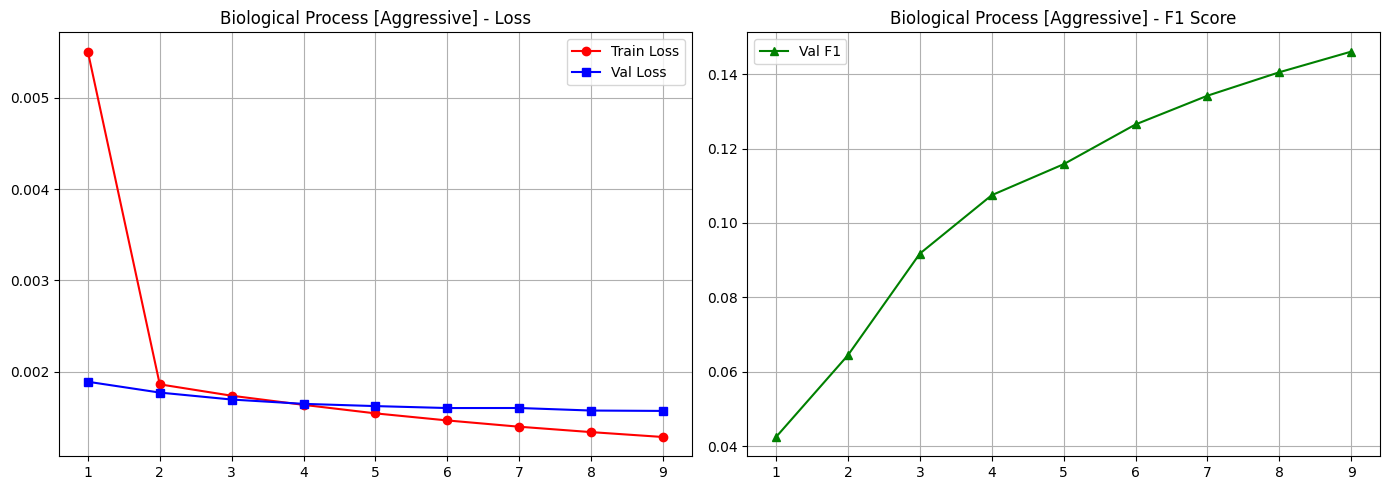


Model 2/3: WideRobust | BS=32 | D1=2048 D2=1024 | Drop=0.4
Ep 01 | Train 0.0038 | Val 0.0019 | F1 0.0517 | LR 9.98e-04
Ep 05 | Train 0.0015 | Val 0.0017 | F1 0.1261 | LR 9.62e-04
Ep 10 | Train 0.0012 | Val 0.0016 | F1 0.1530 | LR 8.54e-04
🛑 Early stopping (best val_loss=0.0016)


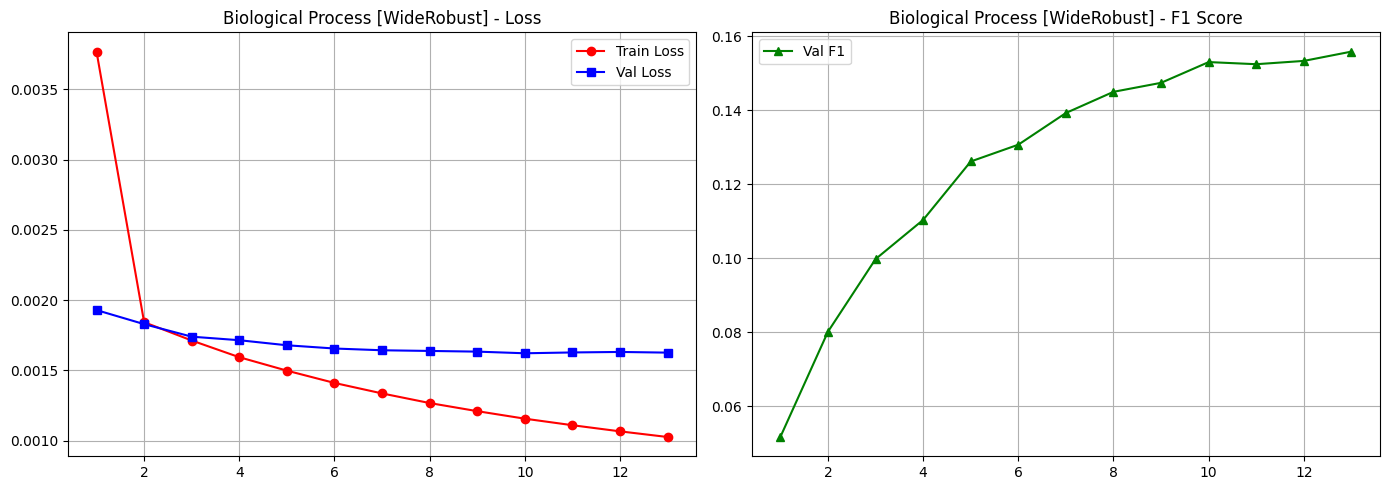


Model 3/3: BalancedMid | BS=32 | D1=1024 D2=768 | Drop=0.3
Ep 01 | Train 0.0043 | Val 0.0019 | F1 0.0566 | LR 9.98e-04
Ep 05 | Train 0.0015 | Val 0.0016 | F1 0.1269 | LR 9.62e-04
🛑 Early stopping (best val_loss=0.0017)


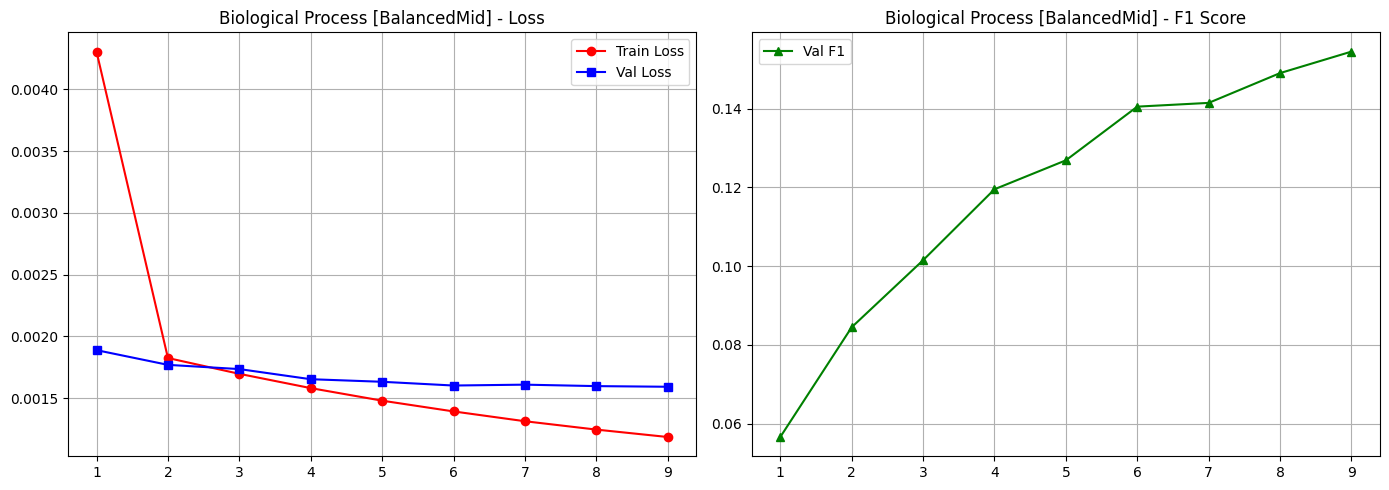

Test proteins: 224309


Predict:   0%|          | 0/3505 [00:00<?, ?it/s]

✅ Raw predictions (P): 15,297,792

Training Aspect: Molecular Function (F)
Proteins: 58001 | Classes: 6616

Model 1/3: Aggressive | BS=32 | D1=1024 D2=512 | Drop=0.3
Ep 01 | Train 0.0055 | Val 0.0018 | F1 0.3645 | LR 9.98e-04
Ep 05 | Train 0.0012 | Val 0.0013 | F1 0.3902 | LR 9.62e-04
Ep 10 | Train 0.0009 | Val 0.0012 | F1 0.4059 | LR 8.54e-04
🛑 Early stopping (best val_loss=0.0013)


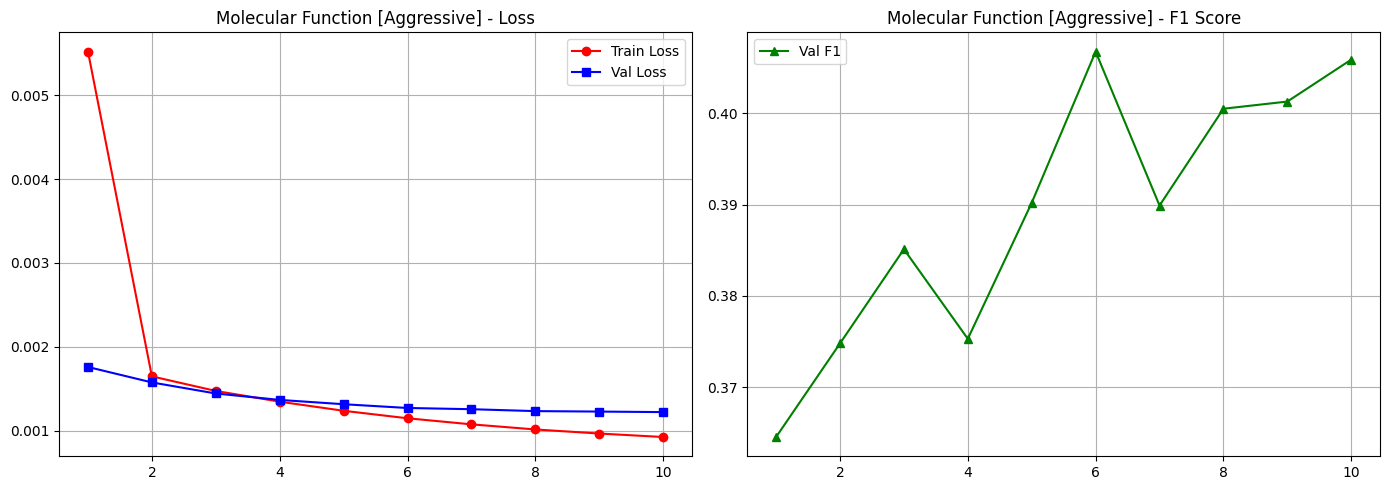


Model 2/3: WideRobust | BS=32 | D1=2048 D2=1024 | Drop=0.4
Ep 01 | Train 0.0037 | Val 0.0017 | F1 0.3589 | LR 9.98e-04
Ep 05 | Train 0.0012 | Val 0.0013 | F1 0.3783 | LR 9.62e-04
Ep 10 | Train 0.0009 | Val 0.0012 | F1 0.3962 | LR 8.54e-04
🛑 Early stopping (best val_loss=0.0012)


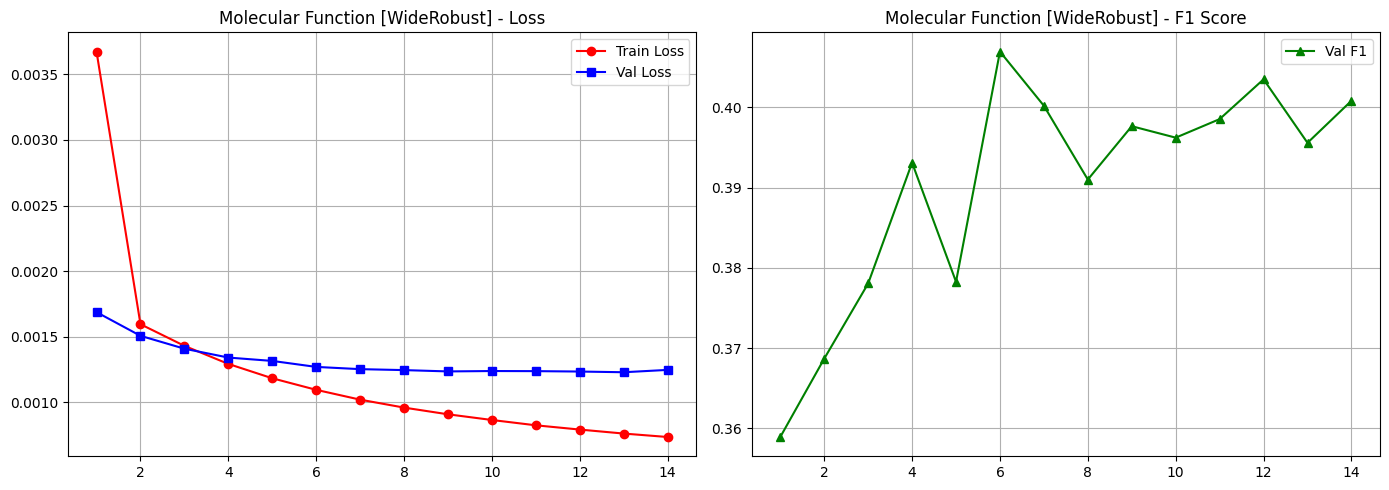


Model 3/3: BalancedMid | BS=32 | D1=1024 D2=768 | Drop=0.3
Ep 01 | Train 0.0042 | Val 0.0017 | F1 0.3553 | LR 9.98e-04
Ep 05 | Train 0.0012 | Val 0.0013 | F1 0.3829 | LR 9.62e-04
🛑 Early stopping (best val_loss=0.0013)


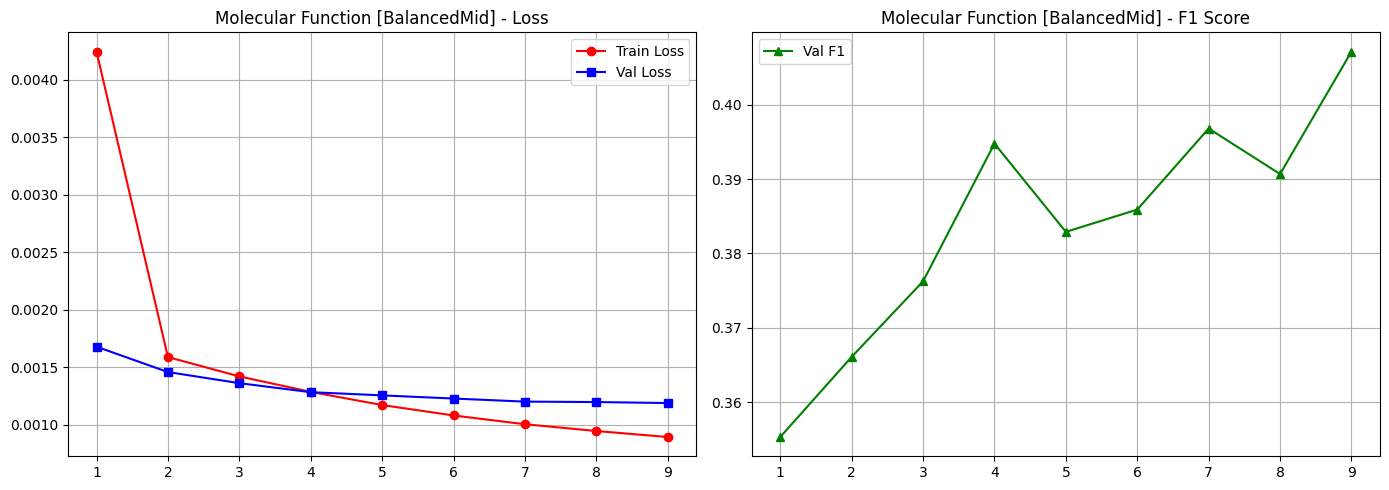

Test proteins: 224309


Predict:   0%|          | 0/3505 [00:00<?, ?it/s]

✅ Raw predictions (F): 5,620,968

Training Aspect: Cellular Component (C)
Proteins: 60292 | Classes: 2651

Model 1/3: Aggressive | BS=32 | D1=1024 D2=512 | Drop=0.3
Ep 01 | Train 0.0080 | Val 0.0041 | F1 0.3424 | LR 9.98e-04
Ep 05 | Train 0.0033 | Val 0.0034 | F1 0.3701 | LR 9.62e-04
Ep 10 | Train 0.0028 | Val 0.0032 | F1 0.3721 | LR 8.54e-04
🛑 Early stopping (best val_loss=0.0033)


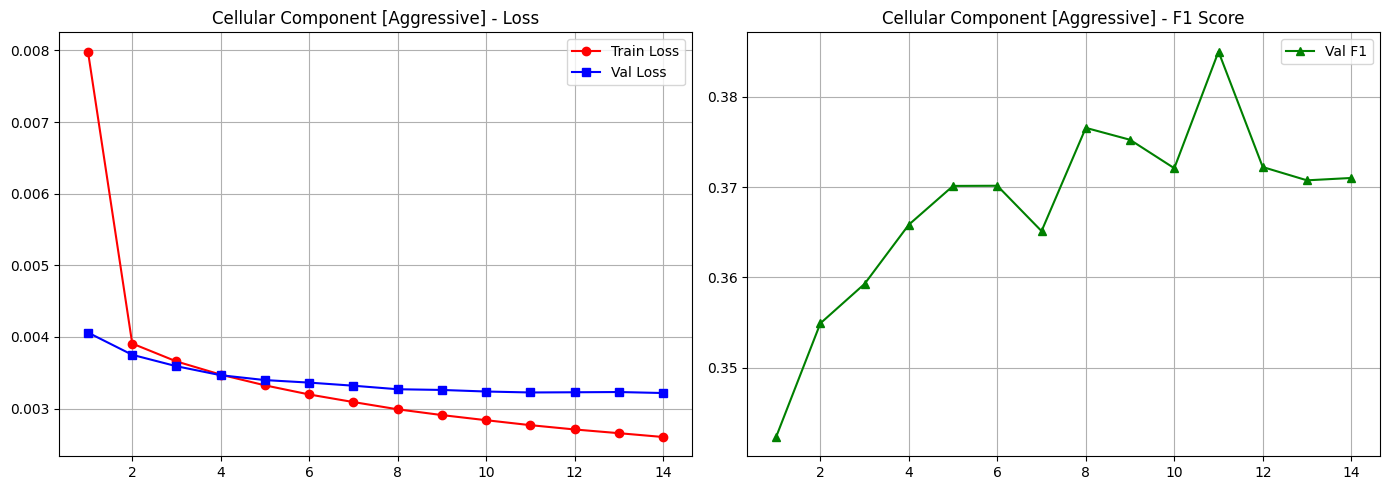


Model 2/3: WideRobust | BS=32 | D1=2048 D2=1024 | Drop=0.4
Ep 01 | Train 0.0062 | Val 0.0039 | F1 0.3369 | LR 9.98e-04
Ep 05 | Train 0.0033 | Val 0.0033 | F1 0.3628 | LR 9.62e-04
Ep 10 | Train 0.0028 | Val 0.0032 | F1 0.3529 | LR 8.54e-04
🛑 Early stopping (best val_loss=0.0032)


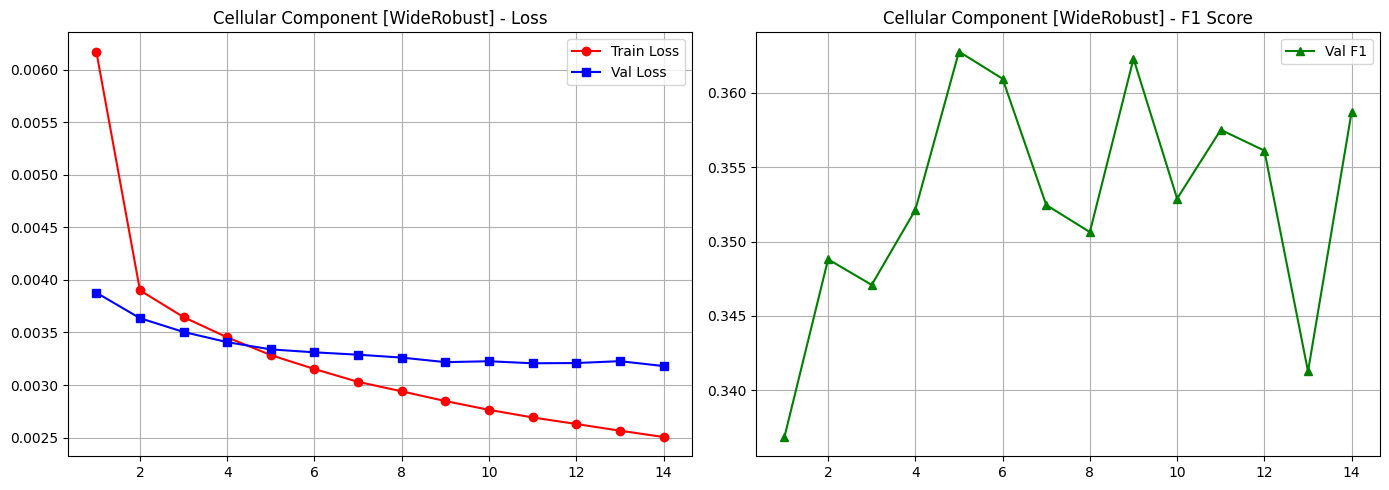


Model 3/3: BalancedMid | BS=32 | D1=1024 D2=768 | Drop=0.3
Ep 01 | Train 0.0067 | Val 0.0039 | F1 0.3493 | LR 9.98e-04
Ep 05 | Train 0.0032 | Val 0.0033 | F1 0.3615 | LR 9.62e-04
Ep 10 | Train 0.0027 | Val 0.0032 | F1 0.3602 | LR 8.54e-04
🛑 Early stopping (best val_loss=0.0033)


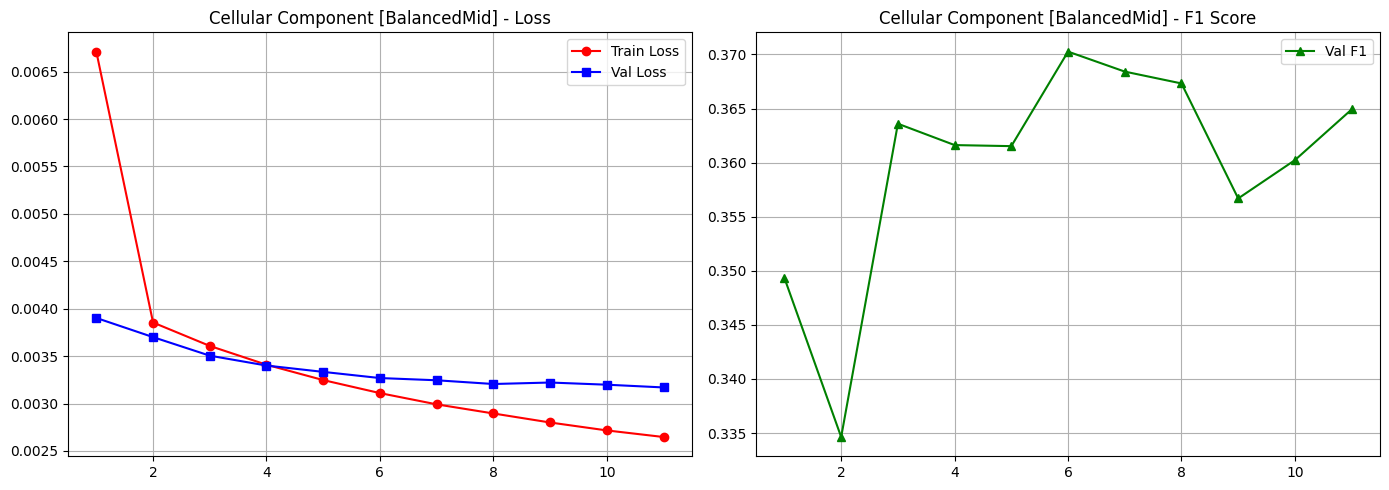

Test proteins: 224309


Predict:   0%|          | 0/3505 [00:00<?, ?it/s]

✅ Raw predictions (C): 5,638,933

Total raw predictions: 26,557,693


In [10]:
train_terms = pd.read_csv(CFG.TRAIN_TERMS, sep="\t")
aspects = {"Biological Process": "P", "Molecular Function": "F", "Cellular Component": "C"}

# input dimension: ESM2 1280 + (85 scaled manual + 20 taxonomy)
sample_pid = next(iter(train_feats.keys()))
input_dim = 1280 + len(train_feats[sample_pid])
print("Input dim:", input_dim)

ia_map = load_ia_weights(CFG.IA_PATH)

submission_parts = []

for long_name, code in aspects.items():
    print(f"\n{'='*48}\nTraining Aspect: {long_name} ({code})\n{'='*48}")

    aspect_df = train_terms[train_terms["aspect"] == code]
    prot_terms = aspect_df.groupby("EntryID")["term"].apply(list).to_dict()

    # keep only proteins for which we have both embeddings and features
    valid_pids = [p for p in prot_terms.keys() if (p in embed_dict) and (p in train_feats)]
    if not valid_pids:
        print("No valid pids for aspect", code)
        continue

    mlb = MultiLabelBinarizer(sparse_output=True)
    y_train = mlb.fit_transform([prot_terms[p] for p in valid_pids])
    classes = mlb.classes_
    num_classes = len(classes)

    if ia_map is not None:
        ia_vec = np.array(
            [ia_map.get(term, 1.0) for term in classes],
            dtype=np.float32
        )
    else:
        ia_vec = None

    print("Proteins:", len(valid_pids), "| Classes:", num_classes)

    ds = HybridDataset(valid_pids, y_train, embed_dict, train_feats)

    # criterion
    if CFG.USE_IA_WEIGHTED_BCE:
        if ia_map is None:
            raise RuntimeError("USE_IA_WEIGHTED_BCE=True but IA map is missing.")
        # build per-class weights (default 1.0 if missing)
        w = np.array([float(ia_map.get(t, 1.0)) for t in classes], dtype=np.float32)
        criterion = IAWeightedBCEWithLogits(torch.tensor(w, device=CFG.DEVICE))
    else:
        criterion = nn.BCEWithLogitsLoss()

    models = []
    for i, conf in enumerate(CFG.ENSEMBLE_CONFIGS, start=1):
        print(f"\nModel {i}/{len(CFG.ENSEMBLE_CONFIGS)}: {conf['NAME']} | BS={conf['BS']} | D1={conf['D1']} D2={conf['D2']} | Drop={conf['DROP']}")
        model, hist = train_one_model(ds, input_dim, num_classes, conf, criterion)
        plot_history(hist, long_name, conf["NAME"])
        models.append(model)
        gc.collect()
        torch.cuda.empty_cache()

    # inference
    test_pids = [p for p in test_seqs.keys() if (p in embed_dict) and (p in test_feats)]
    test_pids = list(test_pids)
    print("Test proteins:", len(test_pids))

    threshold = CFG.THRESHOLDS[code]
    pred_df = predict_ensemble(
        models=models,
        test_pids=test_pids,
        mlb_classes=classes,
        feat_dict=test_feats,
        emb_dict=embed_dict,
        threshold=threshold,
        min_preds=CFG.MIN_PREDS,
        ia_vec=ia_vec,
        batch_size=64
    )

    print(f"Raw predictions ({code}): {len(pred_df):,}")
    submission_parts.append(pred_df)

    # cleanup
    del models, ds, y_train, mlb
    gc.collect()
    torch.cuda.empty_cache()


raw_df = pd.concat(submission_parts, ignore_index=True)
print("\nTotal raw predictions:", f"{len(raw_df):,}")


## Post-Processing - Ontology Propagation

In [11]:
go_parents = parse_obo_parents(CFG.OBO_FILE)
go_children = parse_obo_children(CFG.OBO_FILE)

# parent propagation (max score)
prop_df = propagate_predictions_to_ancestors(raw_df, go_parents)
print("After propagation:", f"{len(prop_df):,}")

# GOA corrections: NOT propagation (descendants) + positive injection
final_df = prop_df

if os.path.exists(CFG.GOA_PATH):
    print("\nApplying GOA corrections from:", os.path.basename(CFG.GOA_PATH))
    goa = pd.read_csv(CFG.GOA_PATH)

    # normalize expected columns
    col_map = {'db_object_id': 'pid', 'go_id': 'term'}
    for k, v in col_map.items():
        if k in goa.columns and v not in goa.columns:
            goa = goa.rename(columns={k: v})

    # if qualifier exists, do NOT filtering + descendants
    if "qualifier" in goa.columns:
        negs = goa[goa["qualifier"].astype(str).str.contains("NOT", na=False)]
        print("NOT rows:", len(negs))

        descendant_cache = {}
        banned = set()

        unique_neg_terms = negs["term"].astype(str).unique()
        for t in tqdm(unique_neg_terms, desc="Expand NOT descendants"):
            banned.add(t)
            for kid in get_descendants(t, go_children, descendant_cache):
                banned.add(kid)

        neg_pairs = set(zip(negs["pid"].astype(str).values, negs["term"].astype(str).values))

        expanded_neg = set()
        for pid, term in tqdm(neg_pairs, desc="Build pid-term bans"):
            expanded_neg.add((pid, term))
            for kid in get_descendants(term, go_children, descendant_cache):
                expanded_neg.add((pid, kid))

        key = list(zip(final_df["pid"].values, final_df["term"].values))
        mask = np.array([k not in expanded_neg for k in key], dtype=bool)
        removed = int((~mask).sum())
        final_df = final_df.loc[mask].copy()
        print("Removed by NOT:", f"{removed:,}")

        # positives (non-NOT)
        pos = goa[~goa["qualifier"].astype(str).str.contains("NOT", na=False)]
    else:
        pos = goa

    # inject positives as p=1.0 only for proteins in test
    relevant_pids = set(final_df["pid"].unique())
    pos = pos[pos["pid"].astype(str).isin(relevant_pids)]
    pos_df = pd.DataFrame({"pid": pos["pid"].astype(str), "term": pos["term"].astype(str), "p": 1.0})

    before = len(final_df)
    final_df = pd.concat([final_df, pos_df], ignore_index=True)
    final_df = final_df.groupby(["pid", "term"], as_index=False)["p"].max()
    print("Injected positives:", f"{len(pos_df):,}", "| Added net:", f"{len(final_df)-before:,}")

else:
    print("\nNo GOA file found: skipping NOT + GT injection")



Parsing GO parents from go-basic.obo ...
✅ Loaded 40,119 GO terms with parents

Propagating predictions to ancestors (is_a + part_of) ...


Propagating:   0%|          | 0/224309 [00:00<?, ?it/s]

After propagation: 64,915,211

Applying GOA corrections from: selection_ids_goa_uniprot_all.csv
NOT rows: 4863


Expand NOT descendants:   0%|          | 0/1542 [00:00<?, ?it/s]

Build pid-term bans:   0%|          | 0/4499 [00:00<?, ?it/s]

✅ Removed by NOT: 2,808
✅ Injected positives: 2,642,719 | Added net: 508,282


## Submission

In [12]:
final_df = final_df.sort_values(["pid", "p"], ascending=[True, False])
print("\nFinal submission rows:", f"{len(final_df):,}")

final_df.to_csv("submission.tsv", sep="\t", index=False, header=False)
print("Saved submission.tsv")

from IPython.display import FileLink
FileLink("submission.tsv")


✅ Final submission rows: 65,420,685
Saved submission.tsv


/kaggle/working/submission.tsv